# Conditional Gaussian Process Model Evaluation  #

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import dates, pyplot as plt
import realizeddensity.gaussian_process_model as gpm
from bayesiankalman import mcmc
from pandas.tools.plotting import autocorrelation_plot

In [2]:
%matplotlib inline

In [3]:
plt.style.use('seaborn-talk')

In [4]:
results = mcmc.read_nested_hdf('../results/cond_gp_model.tmp.hdf')

In [5]:
estimates = {pd.to_datetime(key, format='%B_%d_%Y') : item for key, item in results['results'].items()}

In [6]:
entire_data = pd.DataFrame(results['data']['values'], index=results['data']['index'].astype('datetime64[s]'))

In [7]:
last_day = np.sort(list(estimates.keys()))[-1]

In [8]:
present_dates = estimates[last_day]['dates'].astype('datetime64[D]')
daily_returns = entire_data.groupby(pd.TimeGrouper('D')).sum().dropna().loc[present_dates]

## Setup ##

In [9]:
percentiles = (5, 25, 50, 75, 95)

In [10]:
real_vols = entire_data.apply(lambda x : x**2).groupby(pd.TimeGrouper('D')).sum().dropna().loc[present_dates]

In [11]:
if 'imeans' in estimates[last_day]:
    imeans_df = pd.DataFrame(estimates[last_day]['imeans'].T,index=present_dates)

In [12]:
if 'ivols' in estimates[last_day]:
    ivols_df = pd.DataFrame(estimates[last_day]['ivols'].T,index=present_dates)
    median_ivols = pd.DataFrame(np.median(ivols_df, axis=1), index=present_dates)


In [13]:
if 'ivols' in results:
    true_ivol_df = pd.DataFrame(results['ivols']['values'], present_dates)

## Evaluation ##

In [14]:
np.percentile(np.sum(estimates[last_day]['ivol_coeff'][:,1:],axis=1), percentiles)

array([ 0.96471854,  0.96619334,  0.96722249,  0.96824361,  0.96970874])

In [15]:
np.percentile(np.sum(estimates[last_day]['imean_coeff'][:,1:2], axis=1), percentiles)

array([-1.23253149, -1.15875133, -1.0277303 , -0.78493975, -0.58945023])

In [51]:
mcmc.print_quantiles(estimates[last_day], ('imeans', 'ivols', 'noise_vars',
                                          'forecasted_ivols', 'forecasted_data','forecasted_imeans',
                                           'dates'), percentiles)

imean_coeff
    5th pct  25th pct  50th pct  75th pct  95th pct
0  0.000005  0.000026  0.000060  0.000115  0.000258
1 -1.232531 -1.158751 -1.027730 -0.784940 -0.589450
2 -0.964552 -0.897377 -0.766997 -0.022237  0.195350
3 -0.000040 -0.000017 -0.000004  0.000008  0.000028
ivol_coeff
    5th pct  25th pct  50th pct  75th pct  95th pct
0 -0.383381 -0.367357 -0.356165 -0.345059 -0.329132
1  0.389512  0.393417  0.396131  0.398825  0.402708
2  0.220083  0.224903  0.228286  0.231650  0.236458
3  0.137631  0.142407  0.145738  0.149086  0.153830
4  0.021623  0.026321  0.029597  0.032839  0.037517
5  0.081801  0.085265  0.087652  0.090036  0.093476
6  0.036752  0.039632  0.041613  0.043606  0.046414
7  0.008505  0.011478  0.013521  0.015580  0.018520
8  0.020773  0.023107  0.024738  0.026349  0.028675
ivols_accepted
   5th pct  25th pct  50th pct  75th pct  95th pct
0   0.9365     0.942    0.9455     0.949     0.954
ivol_innov_var
    5th pct  25th pct  50th pct  75th pct  95th pct
0  0.285787  

In [17]:
np.percentile(np.var(imeans_df, axis=0), percentiles)

array([  4.59926331e-08,   3.99631792e-07,   8.85691029e-07,
         1.57212700e-06,   2.80754946e-06])

### Daily Returns ###

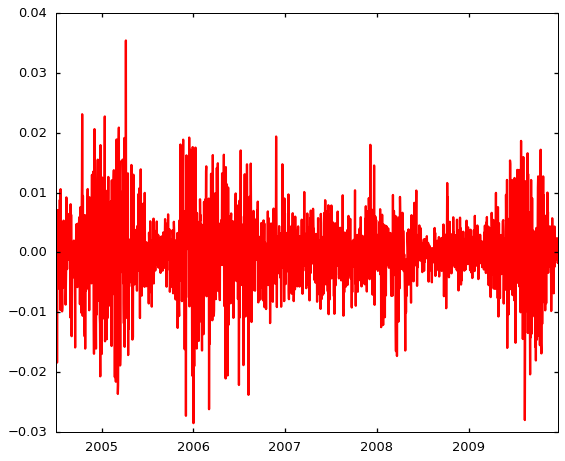

In [18]:
data_fig, data_ax = plt.subplots(1, 1)
data_ax.plot(daily_returns.loc[present_dates],color='red')
data_ax.xaxis.set_major_locator(dates.MonthLocator(interval=12))
# data_ax.set_ylim(-0.08, 0.08)
data_fig.set_size_inches(9, 7.5)
data_fig.savefig('../paper/figures/data.tmp.png')

In [19]:
pd.DataFrame(np.corrcoef(estimates[last_day]['imean_coeff'].T))

0         1         2         3
0  1.000000 -0.201780 -0.147970 -0.018864
1 -0.201780  1.000000  0.899621 -0.127998
2 -0.147970  0.899621  1.000000 -0.124462
3 -0.018864 -0.127998 -0.124462  1.000000

In [20]:
pd.DataFrame(np.corrcoef(estimates[last_day]['ivol_coeff'].T))

0         1         2         3         4         5         6  \
0  1.000000  0.056211  0.025662  0.001895  0.002197  0.039294  0.072763   
1  0.056211  1.000000 -0.582131 -0.165647 -0.107973  0.090033 -0.009374   
2  0.025662 -0.582131  1.000000 -0.364967 -0.179142  0.014283 -0.008127   
3  0.001895 -0.165647 -0.364967  1.000000 -0.425524 -0.122329  0.019060   
4  0.002197 -0.107973 -0.179142 -0.425524  1.000000 -0.417164  0.006681   
5  0.039294  0.090033  0.014283 -0.122329 -0.417164  1.000000 -0.375420   
6  0.072763 -0.009374 -0.008127  0.019060  0.006681 -0.375420  1.000000   
7  0.074971  0.008310 -0.006090  0.009496  0.003315 -0.030550 -0.476034   
8  0.233609 -0.005472  0.025382 -0.018107  0.017331 -0.042833 -0.039198   

          7         8  
0  0.074971  0.233609  
1  0.008310 -0.005472  
2 -0.006090  0.025382  
3  0.009496 -0.018107  
4  0.003315  0.017331  
5 -0.030550 -0.042833  
6 -0.476034 -0.039198  
7  1.000000 -0.618884  
8 -0.618884  1.000000

<a list of 20 Patch objects>

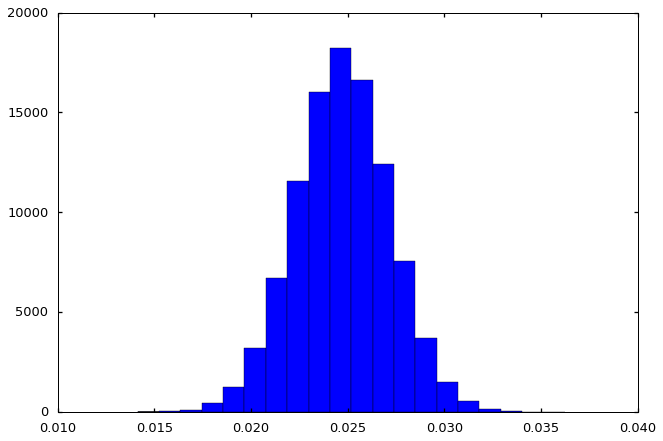

In [21]:
plt.hist(estimates[last_day]['ivol_coeff'][:,8], bins=20)[-1]

### Estimated Imeans Plot ###

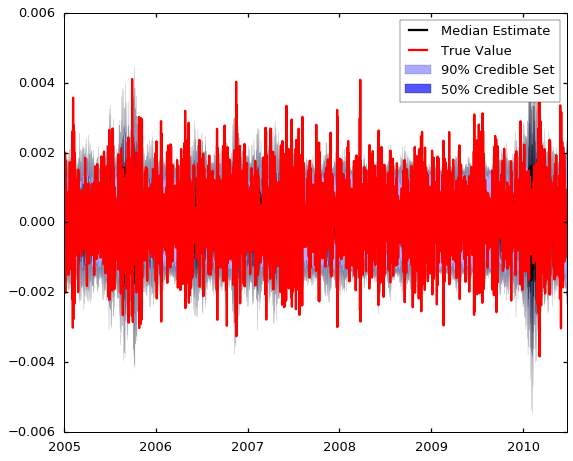

In [22]:
if 'imeans' in estimates[last_day]:
    imeans_est_fig, imeans_est_ax = plt.subplots(1,1)
    mcmc.fan_plot(imeans_est_ax, imeans_df,percentiles, c='black',
                  labels=['Median Estimate',  '90% Credible Set', '50% Credible Set'])

    if 'imeans' in results.keys():
        imean_est_xlimits = imeans_est_ax.get_lines()[0].get_xdata()
        imeans_est_ax.plot(imean_est_xlimits, results['imeans']['values'], label='True Value', c='red')
    imeans_est_ax.legend()
    imeans_est_ax.xaxis.set_major_locator(dates.YearLocator())
    plt.setp(imeans_est_ax.get_xticklabels(), rotation=0)
#    imeans_est_ax.set_ylim(2, 2.01)
    imeans_est_fig.set_size_inches(9, 7.5)
    imeans_est_fig.savefig('../paper/figures/stochastic_means_estimated.tmp.png')

In [23]:
if 'imeans' in results.keys():
    differences = np.ravel(results['imeans']['values']) - np.median(imeans_df.values, axis=1)
    normed_diffs = differences / np.ravel(results['imeans']['values'])
    print("The median absolute normalized difference is " + str(np.median(np.abs(normed_diffs))))

The median absolute normalized difference is 0.955220334932


### Ivols Est Plot ###

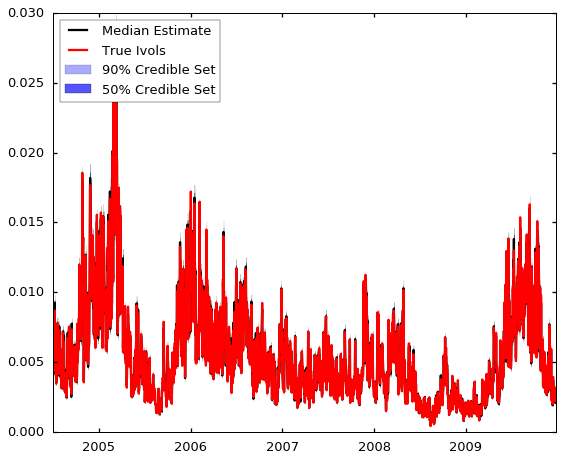

In [24]:
if 'ivols' in estimates[last_day]:
    ivols_est_fig, ivols_est_ax = plt.subplots(1,1)
    mcmc.fan_plot(ivols_est_ax, np.sqrt(ivols_df), percentiles, c='black', 
                 labels=['Median Estimate', '90% Credible Set', '50% Credible Set'])
    ivols_est_xlimits = ivols_est_ax.get_lines()[0].get_xdata()
    ivols_est_ax.xaxis.set_major_locator(dates.MonthLocator(interval=12))

    if 'ivols' in results.keys():
        ivols_est_ax.plot(ivols_est_xlimits, np.sqrt(true_ivol_df), 'red', label='True Ivols')
    else:
        ivols_est_ax.plot(ivols_est_xlimits, np.sqrt(real_vols.loc[present_dates]),'green', label='Real Vols')
    ivols_est_ax.legend(loc='upper left')
    plt.setp(ivols_est_ax.get_xticklabels(), rotation=0)
#     ivols_est_ax.set_ylim(-.04, .04)
    ivols_est_fig.set_size_inches(9, 7.5)
    ivols_est_fig.savefig('../paper/figures/stochastic_vols_estimated.tmp.png')

In [25]:
if 'ivols' in results.keys():
    differences = real_vols.loc[present_dates].values.ravel() - np.median(ivols_df.values, axis=1)
    normed_diffs = differences / real_vols.loc[present_dates].values.ravel()
    print("The median normalized absolute difference is " + str(np.median(np.abs(normed_diffs))))

The median normalized absolute difference is 0.00712117117917


In [26]:
np.percentile(estimates[last_day]['imean_innov_var'] / np.var(estimates[last_day]['imeans'], axis=1), percentiles)

array([ 0.18445386,  0.275234  ,  0.45849548,  0.81391828,  4.78169929])

In [27]:
prediction_var = (estimates[last_day]['imean_innov_var'] + estimates[last_day]['imean_coeff'][:,-1]**2 * 
                  estimates[last_day]['ivol_innov_var'])
np.percentile(prediction_var / np.var(estimates[last_day]['imeans'], axis=1), percentiles)

array([ 0.18447119,  0.27528814,  0.45867061,  0.81445373,  4.78340357])

## Autocorrelation Plots ##

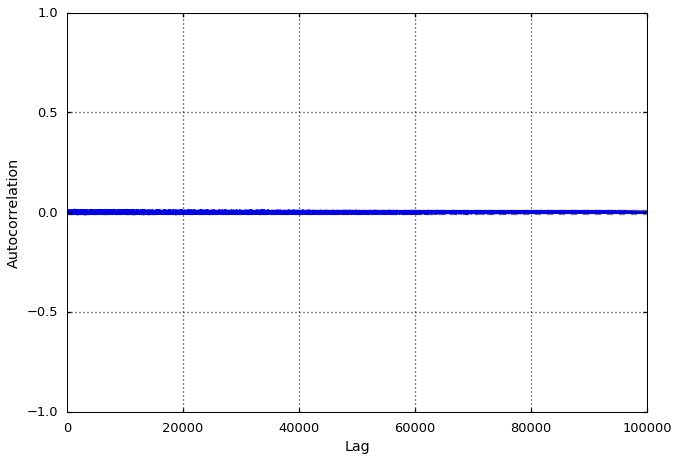

In [28]:
autocorrelation_plot(estimates[last_day]['ivol_coeff'][:,6])

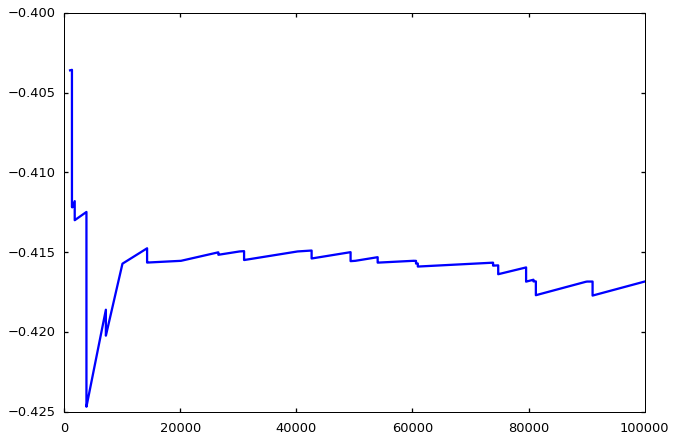

In [29]:
params = estimates[last_day]['ivol_coeff'][:,0]
pd.DataFrame(params).expanding(1000).apply(lambda x : np.percentile(x, [.01])).plot(legend=None)

## Forecasting ##

In [30]:
if 'forecasted_ivols' in estimates[last_day].keys():
    nsims, horizon = estimates[last_day]['forecasted_ivols'].shape
    forecast_data_df = pd.DataFrame(index=daily_returns.index, columns=np.arange(nsims), dtype='float')
    forecast_imeans_df = pd.DataFrame(index=daily_returns.index, columns=np.arange(nsims), dtype='float')
    forecast_ivols_df = pd.DataFrame(index=daily_returns.index, columns=np.arange(nsims), dtype='float')
                            

In [31]:
if 'forecasted_ivols' in estimates[last_day].keys():
    for last_estimated_day, data in estimates.items():
        forecast_data, forecast_ivols, forecast_imeans = [data[key] for key in
                                                                ['forecasted_data', 'forecasted_ivols',
                                                                 'forecasted_imeans']]
        if last_estimated_day != last_day:
            future_date = daily_returns.loc[last_estimated_day:].index[horizon]
            forecast_data_df.loc[future_date] = np.sum(forecast_data[:,-1,:], axis=-1)
            forecast_ivols_df.loc[future_date] = forecast_ivols[:,-1]
            forecast_imeans_df.loc[future_date] = np.atleast_2d(forecast_imeans.T).T[:,-1]




In [32]:
if 'forecasted_ivols' in estimates[last_day].keys():
    future_dates = forecast_data_df.dropna().index
    future_data = daily_returns.loc[future_dates]

### Forecast Ivols Plot ###

In [33]:
if 'forecasted_ivols' in estimates[last_day].keys():
    ivols_fut_fig, ivols_fut_ax = plt.subplots(1,1)
    mcmc.fan_plot(ivols_fut_ax, pd.DataFrame(np.sqrt(forecast_ivols_df.dropna().values), future_dates), percentiles,
                        color='black', labels=['Median Estimate', '90% Credible Set', '50% Credible Set'])
    ivols_fut_xlimits = ivols_fut_ax.get_lines()[0].get_xdata()
    ivols_fut_ax.xaxis.set_major_locator(dates.MonthLocator(interval=12))
    if 'ivols' in results.keys():
        ivols_fut_ax.plot(ivols_fut_xlimits, np.sqrt(true_ivol_df.loc[future_dates]), 'red', label='True Vols')
    else:
        ivols_fut_ax.plot(ivols_fut_xlimits, np.sqrt(real_vols.loc[future_dates]),'red')
    ivols_fut_ax.legend(loc='upper left')
    plt.setp(ivols_fut_ax.get_xticklabels(), rotation=0)
    ivols_fut_ax.set_ylim(0, 0.08)
    ivols_fut_fig.set_size_inches(9, 7.5)
    ivols_fut_fig.savefig('../paper/figures/stochastic_vols_forecasted.tmp.pnghttps://cmake.org/files/v3.5/cmake-3.5.2.tar.Z')

### Mean Return No Smoothing ###

In [34]:
if 'forecasted_ivols' in estimates[last_day].keys():
    mean_est2_fig, mean_est2_ax = plt.subplots(1,1)
    mean_est2_ax.plot(daily_returns, color='black', label='Median')
    mean_est2_fig = mean_est2_ax.get_figure()
    data_fut_xlimits2 = mean_est2_ax.get_lines()[0].get_xdata()
    mean_est2_ax.fill_between(data_fut_xlimits2,
                             np.squeeze(daily_returns + .674 * np.sqrt(median_ivols)),
                             np.squeeze(daily_returns - .674 * np.sqrt(median_ivols)), 
                             color='blue', alpha=1, label='50% Credible Set')
    mean_est2_ax.fill_between(data_fut_xlimits2, 
                              np.squeeze(daily_returns + 1.645 * np.sqrt(median_ivols)),
                              np.squeeze(daily_returns - 1.645 * np.sqrt(median_ivols)), 
                              color='blue', alpha=.5, label='90% Credible Set')
    mean_est2_ax.xaxis.set_major_locator(dates.YearLocator())
    mean_est2_ax.legend(loc='upper left')
    mean_est2_ax.set_ylim([-0.08, 0.08])
    plt.setp(mean_est2_ax.get_xticklabels(), rotation=0)
    mean_est2_fig.set_size_inches(9, 7.5)
    mean_est2_fig.savefig('../paper/figures/stochast_density_estimated.tmp.png')

### Forecast Data Plot ### 

In [35]:
if 'forecasted_ivols' in estimates[last_day].keys():
    data_pred_fig, data_pred_ax = plt.subplots(1,1)
    mcmc.fan_plot(data_pred_ax, forecast_data_df.dropna(), percentiles,color='black')
    data_pred_xlimits = data_pred_ax.get_lines()[0].get_xdata()
    data_pred_ax.plot(data_pred_xlimits, future_data.loc[future_dates].values,'red')
    data_pred_ax.xaxis.set_major_locator(dates.MonthLocator(interval=6))
    data_pred_ax.legend(['Median', 'Daily Return', '90% Credible Set', '50% Credible Set'])
    plt.setp(data_pred_ax.get_xticklabels(), rotation=0)
    data_pred_ax.set_ylim(-0.08, 0.08)
    data_pred_fig.set_size_inches(9, 7.5)
    data_pred_fig.savefig('../paper/figures/stochastic_density_forecasted.tmp.png')


In [36]:
if 'forecasted_ivols' in estimates[last_day].keys():
    est_imeans = pd.DataFrame(np.median(estimates[last_day]['imeans'],0),
                          index=estimates[last_day]['dates'].astype('datetime64[D]'))

In [37]:
if 'imeans' in results:
    true_imeans_df = pd.DataFrame(results['imeans']['values'], results['imeans']['index'].astype('datetime64[s]'))

### Forecast Mean Plot ###

In [38]:
if 'forecasted_ivols' in estimates[last_day].keys():
    imeans_pred_fig, imeans_pred_ax = plt.subplots(1,1)
    mcmc.fan_plot(imeans_pred_ax, forecast_imeans_df.loc[future_dates], percentiles, 
                 labels=['Median Forecast', '50% Interval Forecast', '90% Interval Forecast'])
    imeans_pred_xlimits = imeans_pred_ax.get_lines()[0].get_xdata()
    imeans_pred_ax.xaxis.set_major_locator(dates.MonthLocator(interval=6))
    if 'imeans' in results:
        imeans_pred_ax.plot(imeans_pred_xlimits, true_imeans_df.loc[future_dates], 'red', label='True Mean')
    else:
        imeans_pred_ax.plot(imeans_pred_xlimits, est_imeans.loc[future_dates].values,'green', 
                            label='Median Estimate')
    imeans_pred_ax.legend()
    plt.setp(imeans_pred_ax.get_xticklabels(), rotation=0)
    imeans_pred_ax.set_ylim(-0.08, 0.08)
    imeans_pred_fig.set_size_inches(9, 7.5)
    imeans_pred_fig.savefig('../paper/figures/stochastic_means_forecasted.tmp.png')

In [39]:
if 'forecasted_ivols' in estimates[last_day].keys():    
    data_pit = mcmc.probability_integral_transform(forecast_data_df.dropna().values, future_data.values)

### Data PIT ### 

In [40]:
if 'forecasted_ivols' in estimates[last_day].keys():
    data_pit_fig, data_pit_ax = plt.subplots(1,1)
    pd.DataFrame(data_pit).plot(kind='density', ax=data_pit_ax, legend=None, color='g', bw_method='scott')
    data_pit_ax.hist(data_pit, normed=True, bins=10, color='b')
    data_pit_ax.set(xlim=[0,1], ylabel="")  
    data_pit_fig.set_size_inches(9, 7.5)
    data_pit_fig.savefig('../paper/figures/stochastic_density_pit.tmp.png')

In [41]:
if 'forecasted_ivols' in estimates[last_day].keys():
    print(stats.kstest(data_pit.ravel(), 'uniform'))

In [42]:
if 'forecasted_ivols' in estimates[last_day].keys():
    autocorrelation_plot(data_pit)
    plt.ylabel("")
    plt.gcf().set_size_inches(9, 7.5)
    plt.savefig('../paper/figures/stochastic_density_pit_autocorr.tmp.png')

In [43]:
if 'forecasted_ivols' in estimates[last_day].keys():
    if 'ivols' in results:
        ivols_pit = mcmc.probability_integral_transform(fosimulated_model.ivol_innov_varrecast_ivols_df.dropna().values, 
                                                    true_ivol_df.loc[future_dates].values)
    else: 
        ivols_pit = mcmc.probability_integral_transform(forecast_ivols_df.dropna().values, 
                                                    median_ivols.loc[future_dates].values)

In [44]:
if 'forecasted_ivols' in estimates[last_day].keys():
    print(stats.kstest(ivols_pit.ravel(), 'uniform'))

### Ivols PIT ### 

In [45]:
if 'forecasted_ivols' in estimates[last_day].keys():
    ivols_pit_fig, ivols_pit_ax = plt.subplots(1,1)
    pd.DataFrame(ivols_pit).plot(kind='density', ax=ivols_pit_ax, legend=None, color='g', bw_method='scott')
    ivols_pit_ax.hist(ivols_pit, normed=True, bins=10, color='b')
    ivols_pit_ax.set(xlim=[0,1], ylabel="")  
    ivols_pit_fig.set_size_inches(9, 7.5)
    ivols_pit_fig.savefig('../paper/figures/stochastic_vols_pit.tmp.png')

In [46]:
if 'forecasted_ivols' in estimates[last_day].keys():
    autocorrelation_plot(ivols_pit)

In [47]:
if 'forecasted_ivols' in estimates[last_day].keys():
    if 'imeans' in results.keys():
        imeans_pit = mcmc.probability_integral_transform(forecast_imeans_df.dropna().values, 
                                                         results['imeans']['values'])
    else:
        imeans_pit = mcmc.probability_integral_transform(forecast_imeans_df.dropna().values, 
                                                         np.median(imeans_df.loc[future_dates], axis=0))

In [48]:
if 'forecasted_ivols' in estimates[last_day].keys():
    print(stats.kstest(imeans_pit.ravel(), 'uniform'))

### Imean Pit ###

In [49]:
if 'forecasted_ivols' in estimates[last_day].keys():
    imeans_pit_fig, imeans_pit_ax = plt.subplots(1,1)
    pd.DataFrame(imeans_pit).plot(kind='density', ax=imeans_pit_ax, legend=None, color='g', bw_method='scott')
    imeans_pit_ax.hist(imeans_pit, normed=True, bins=10, color='b')
    imeans_pit_ax.set(xlim=[0,1], ylabel="")  
    imeans_pit_fig.set_size_inches(9, 7.5)
    imeans_pit_fig.savefig('../paper/figures/stochastic_means_pit.tmp.png')

In [50]:
if 'forecasted_ivols' in estimates[last_day].keys():
    autocorrelation_plot(imeans_pit**2)